# Shakespeare LSTM

## About Dataset
Download: http://www.gutenberg.org/files/100/old/1994-01-100.zip

How to use it: https://github.com/TalwalkarLab/leaf/tree/master/data/shakespeare

Go to the directory and run the following command in the terminal.
```
./preprocess.sh -s niid --sf 0.2 -k 0 -t sample -tf 0.8
```

## About Experiment

(See Chapter 3)

**Task**

On this data we train a stacked character-level LSTM language model, which after reading each character in a line, predicts the next character.

**Architecture**

- The model takes a series of characters as input and embeds each of these into a learned 8 dimensional space. (embedding_len = 8)
- The embedded characters are then processed through 2 LSTM layers, each with 256 nodes. (num_layers=2, n_hidden = 256)
- Finally the output of the second LSTM layer is sent to a softmax output layer with one node per character.
- The full model has 866,578 parameters, and we trained using an unroll length of 80 characters. (seq_len = 80, num_classes = 80)

In [ ]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy

import torch
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_noniid, CustomSubset


torch.manual_seed(42)
np.random.seed(42)

In [ ]:
from data_utils import get_shakespeare

train_path = 'all_data_niid_2_keep_0_train_9.json'
test_path = 'all_data_niid_2_keep_0_test_9.json'

train_input, train_target, train_client = get_shakespeare(train_path)
test_input, test_target, _ = get_shakespeare(test_path)

In [ ]:
len(train_input), len(train_target), len(test_input), len(test_target)

(742106, 742106, 71784, 71784)

In [ ]:
# Step_00. load data

trainset = TensorDataset(torch.tensor(train_input), torch.tensor(train_target))
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2)

testset = TensorDataset(torch.tensor(test_input), torch.tensor(test_target))
testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2)

train_idcs, test_idcs = np.arange(len(trainset)), np.arange(len(testset)) # in case of validating set
train_labels = np.asarray(train_client)

In [ ]:
# Step_01. iid VS non-iid
from data_utils import split_noniid

client_noniid_idcs = split_noniid(train_idcs, train_labels, alpha=1, n_clients=100)
client_noniid_data = [CustomSubset(trainset, idcs) for idcs in client_noniid_idcs]

test_data = CustomSubset(testset, test_idcs, transforms.Compose([transforms.ToTensor()]))


In [ ]:
# Step_04. Build models
import torch.nn as nn
import torch.nn.functional as F

use_gpu = True
use_gpu = use_gpu and torch.cuda.is_available()
device = torch.device('cuda') if use_gpu else torch.device('cpu')

class ModelLSTMShakespeare(nn.Module):
    def __init__(self):
        super(ModelLSTMShakespeare, self).__init__()
        self.embedding_len = 8
        self.seq_len = 80
        self.num_classes = 80
        self.n_hidden = 256
        self.batch_size = 32

        self.embeds = nn.Embedding(self.seq_len, self.embedding_len)
        self.multi_lstm = nn.LSTM(input_size=self.embedding_len, hidden_size=self.n_hidden, num_layers=2, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(self.n_hidden, self.num_classes)

    def forward(self, x, out_activation=False):
        x = x.to(torch.int64)
        x_ = self.embeds(x)
        h0 = torch.rand(2, x_.size(0), self.n_hidden).to(device)
        c0 = torch.rand(2, x_.size(0), self.n_hidden).to(device)
        activation, (h_n, c_n) = self.multi_lstm(x_,(h0,c0))

        fc_ = activation[:, -1, :]

        output = self.fc(fc_)
        if out_activation:
            return output, activation
        else:
            return output



In [ ]:
# FL_settings
from fl_devices import Server, Client

batch_size = 128

clients = [Client(ModelLSTMShakespeare, lambda x : torch.optim.SGD(x, lr=0.01, momentum=0.9), dat, idnum=i, batch_size=batch_size)
           for i, dat in enumerate(client_noniid_data)]
server = Server(ModelLSTMShakespeare, test_data)

In [ ]:
# Step_05. Training on iid data
from helper import ExperimentLogger, display_train_stats

def fl_train(server, clients, pct_participant=0.1, num_local_epochs=1, max_rounds=100, target_accuracy=0.97):

    cfl_stats = ExperimentLogger()

    for c_round in range(1, max_rounds+1):

        if c_round == 1:
            for client in clients:
                client.synchronize_with_server(server)

        participating_clients = server.select_clients(clients, frac=pct_participant)

        for client in participating_clients:
            train_stats = client.compute_weight_update(epochs=num_local_epochs)
            client.reset()

        server.aggregate_weight_updates(participating_clients)

        acc_clients = [client.evaluate() for client in clients]

        cfl_stats.log({"acc_clients" : acc_clients, "rounds" : c_round})

        title = f"C={pct_participant}, E={num_local_epochs}"

        display_train_stats(cfl_stats, max_rounds, title=title, target_accuracy=target_accuracy)

        return cfl_stats


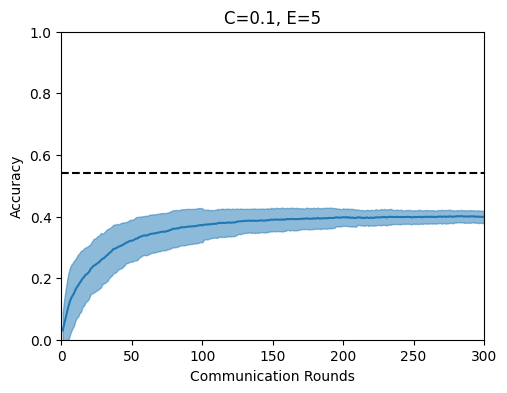

In [ ]:
fl_train(server, clients, num_local_epochs=5, max_rounds=300, target_accuracy=0.54)